In [2]:
from reconstruction import reconstruct_volume_gpu, reconstruct_vol_from_img_gpu
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import os
import glob
import h5py
from tqdm.auto import tqdm
from lfm.util import create_projection_image, volume_to_gif

In [3]:
pn_rec = r"Y:/hpc/r/lfm2025/recordings"
includes = ['']
excludes = []

recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_rec, '*'))), reverse=True) if os.path.exists(os.path.join(pn_rec, rec, 'psf_filtered.h5'))]
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])]
print('\n'.join(recs))

20250425_1320_PSF_LB_redFB_1-10000_2d_without_coverslip_3


In [4]:
pn_rec = r"Y:/hpc/r/lfm2025/recordings"
dataset_name = "20250425_1320_PSF_LB_redFB_1-10000_2d_without_coverslip_3"
fn = os.path.join(pn_rec, dataset_name, 'psf_filtered.h5')
with h5py.File(fn, 'r') as f:
    # print(f.keys())
    psf = np.array(f['psf'])
    psf_filtered = np.array(f["psf_clean"])
    bg = np.array(f["bg"])
    crop = np.array(f["crop"])
    circle_mask = np.array(f["circle_mask"])



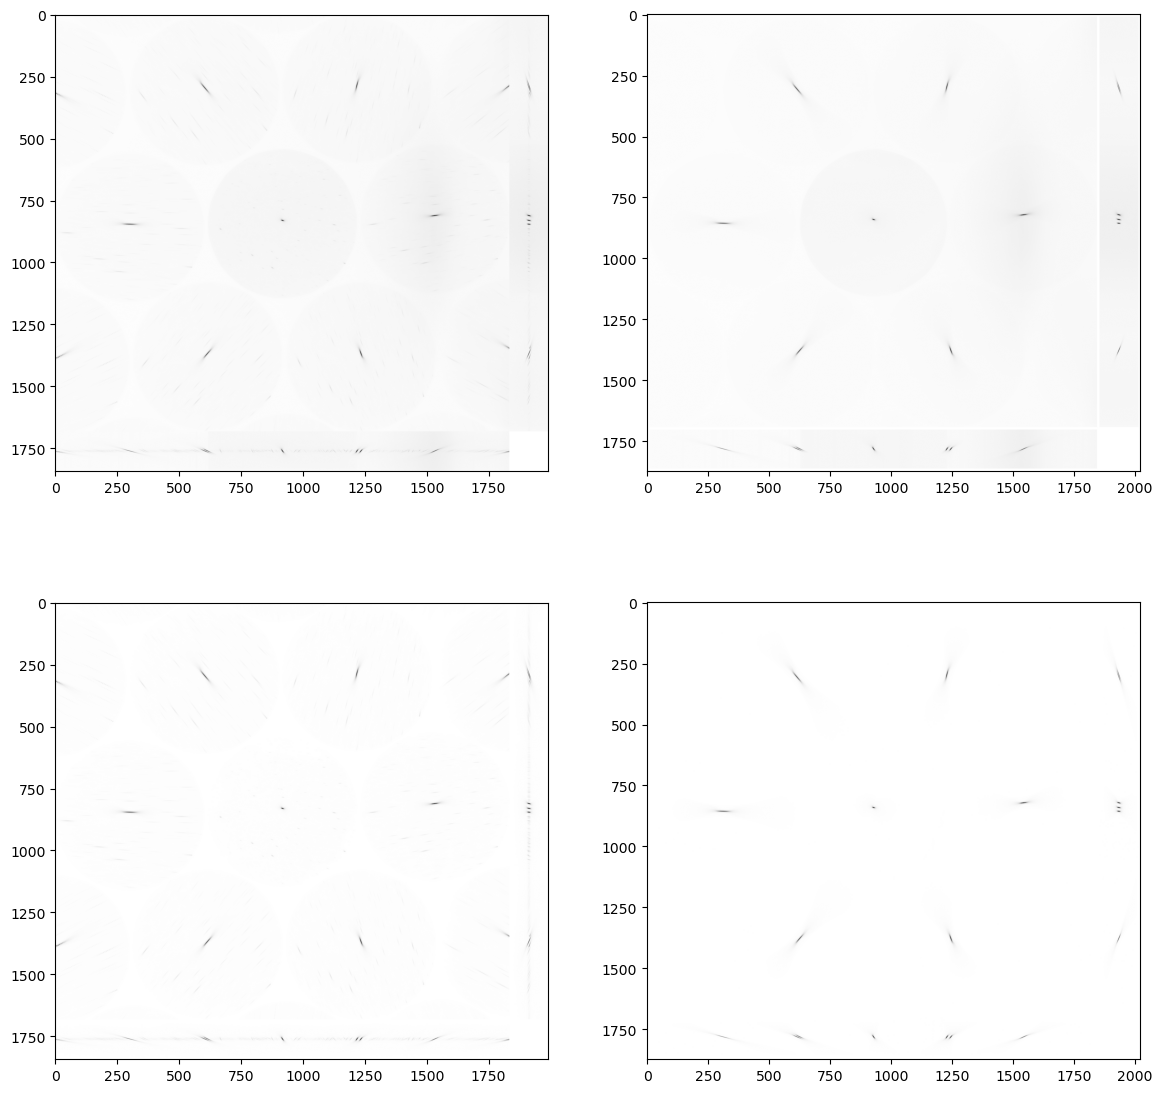

In [5]:
fig, ax = plt.subplots(2,2, figsize=(14, 14))
ax[0,0].imshow(create_projection_image(psf,np.max,pad=0), cmap='binary')
ax[0,1].imshow(create_projection_image(psf_filtered,np.max,pad=10), cmap='binary')
ax[1,0].imshow(create_projection_image(psf-bg,np.max,pad=0), cmap='binary')
ax[1,1].imshow(create_projection_image(psf_filtered-bg,np.max,pad=10), cmap='binary')

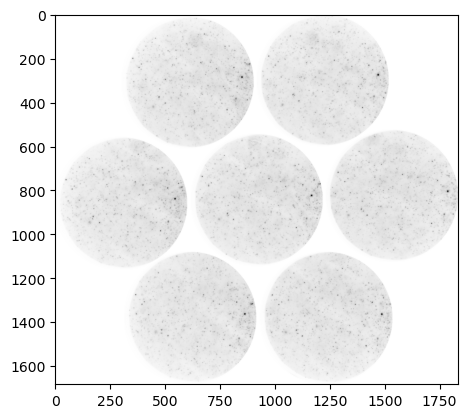

In [6]:
dataset_name = "20250412_1651_LB_redFB_1-1000_3d_with coverslip_2"
fn = os.path.join(pn_rec, dataset_name, 'psf.h5')
with h5py.File(fn, 'r') as f:
    imgs = np.array(f["psf"])
img = imgs[2,crop[0]:crop[1],crop[2]:crop[3]]*circle_mask[crop[0]:crop[1],crop[2]:crop[3]]
plt.imshow(img, cmap='binary')

Initializing memory


  0%|          | 0/30 [00:00<?, ?it/s]

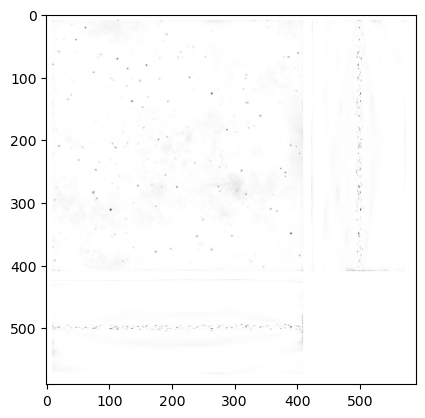

In [8]:
psf1 = psf_filtered-bg
for z in range(psf.shape[0]):
    psf1[z,:,:] = psf1[z,:,:]/psf1[z,:,:].sum()
vol = reconstruct_vol_from_img_gpu(cp.asarray(img),cp.asarray(psf1),roi_size=200, n_iter=30)
plt.imshow(create_projection_image(vol.get(),np.max, pad=10), cmap='binary')

In [ ]:
psf1 = psf_filtered-bg
for z in range(psf.shape[0]):
    psf1[z,:,:] = psf1[z,:,:]/psf1[z,:,:].sum()
vol, loss, mip = reconstruct_volume_gpu(img,psf1,roi_size=200, n_iter=40,plot=True)
plt.imshow(create_projection_image(vol.get(),np.max, pad=10), cmap='binary')

In [9]:
volume_to_gif(mip,gif_path="output_cropped_roi200.gif", cmap="binary")

  0%|          | 0/40 [00:00<?, ?it/s]

GIF saved to: output_cropped_roi200.gif


Simulate a volume to reconstruct

  0%|          | 0/64 [00:00<?, ?it/s]

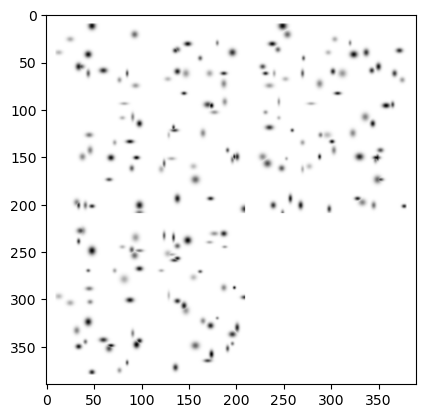

In [10]:
sparseness = 0.00001
intensity_dist = (50, 200)
sigma_dist = (1, 3)

sim_vol = np.zeros_like(vol)
depth, height, width = sim_vol.shape
n_gauss = int(depth * height * width * sparseness)
positions = np.random.rand(n_gauss, 3) * np.array([depth, height, width])
intensities = np.random.uniform(intensity_dist[0], intensity_dist[1], n_gauss)
sigmas = np.random.uniform(sigma_dist[0], sigma_dist[1], (n_gauss, 3))
z_indices, y_indices, x_indices = cp.mgrid[:depth, :height, :width]
# Add each Gaussian to the volume
for i in tqdm(range(n_gauss)):
    z_pos, y_pos, x_pos = positions.astype(np.int16)[i]
    sigma_z, sigma_y, sigma_x = sigmas[i]
    intensity = intensities[i]

    # Calculate 3D Gaussian
    gaussian = intensity * cp.exp(
        -((z_indices - z_pos) ** 2 / (2 * sigma_z ** 2) +
          (y_indices - y_pos) ** 2 / (2 * sigma_y ** 2) +
          (x_indices - x_pos) ** 2 / (2 * sigma_x ** 2))
    )

    # Add to volume
    sim_vol += gaussian

plt.imshow(create_projection_image(sim_vol.get(),np.max, pad=10), cmap='binary')
plt.title("Simulated volume")

  0%|          | 0/160 [00:00<?, ?it/s]

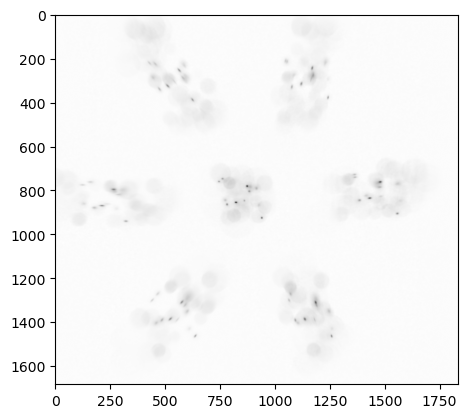

In [11]:
from cupyx.scipy.signal import fftconvolve
sim_img = cp.zeros_like(img)
slice_temp = cp.zeros_like(img)
roi_size = sim_vol.shape[1]
xy_pad = (psf.shape[1]-roi_size)//2
psf_gpu = cp.asarray(psf1)
for z in tqdm(range(psf.shape[0])):
    slice_temp[xy_pad:xy_pad+roi_size,xy_pad:xy_pad+roi_size] = sim_vol[z,:,:]
    forward_pass = fftconvolve(slice_temp, psf_gpu[z,:,:],  mode="same")
    sim_img += forward_pass
plt.imshow(sim_img.get(), cmap='binary')

Initializing memory
Finished initializing memory


Main loop:   0%|          | 0/40 [00:00<?, ?it/s]

Forward Projection:   0%|          | 0/160 [00:00<?, ?it/s]

Back Projection:   0%|          | 0/160 [00:00<?, ?it/s]

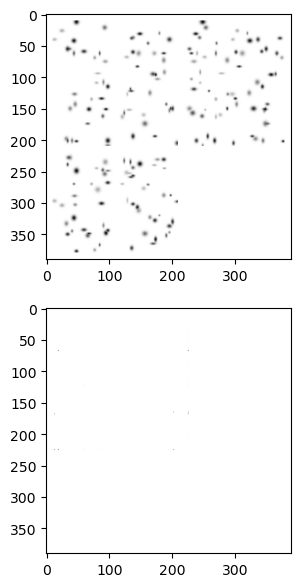

In [12]:
sim_vol_recon, loss, mip = reconstruct_volume_gpu(sim_img,psf1,roi_size=200, n_iter=40,plot=True)
fig, ax = plt.subplots(1,2,figsize = (14,7))
ax[0].imshow(create_projection_image(sim_vol.get(),np.max, pad=10), cmap='binary')
ax[0].set_title("Simulated volume")
ax[1].imshow(create_projection_image(sim_vol_recon.get(),np.max, pad=10), cmap='binary')
ax[1].set_title("Simulated volume reconstructed using psf")


In [15]:
volume_to_gif(mip,gif_path="sim_output_cropped_roi200.gif", cmap="binary")

  0%|          | 0/40 [00:00<?, ?it/s]

GIF saved to: sim_output_cropped_roi200.gif


In [1]:
with h5py.File("simulated_volume.h5", 'w') as f:
    f.create_dataset("simulated_volume", data=sim_vol_recon.get())
    f.create_dataset("psf", data=psf1)
    f.create_dataset("sim_img", data=sim_img.get())


NameError: name 'h5py' is not defined

In [24]:
xy_pad = 201
from cupy.fft import fft2, ifft2, fftshift, ifftshift
psf = cp.asarray(psf1)
size_y = psf.shape[1] + 2 * xy_pad
size_x = psf.shape[2] + 2 * xy_pad
size_z = psf.shape[0]
OTF = cp.zeros((size_z, size_y, size_x), dtype=cp.complex64)
for i in range(size_z):
    OTF[i, :, :] = fft2(ifftshift(cp.pad(psf[i, :, :], ((xy_pad, xy_pad), (xy_pad, xy_pad)), mode='constant')))


In [16]:
i = 0
padded = cp.pad(psf[i, :, :], ((xy_pad, xy_pad), (xy_pad, xy_pad)), mode='constant')
padded.shape

(2085, 2234)

In [17]:
OTF[i,:,:].shape

(2085, 562)

In [21]:
psf = cp.asarray(psf1)
print (psf.shape)
size_x = psf.shape[1] + 2 * xy_pad
size_y = psf.shape[2] + 2 * xy_pad
size_z = psf.shape[0]
OTF = cp.zeros((size_z, size_y, size_x), dtype=cp.complex64)
OTF[:,:,:].shape

(160, 1683, 1832)


(1832, 2085, 562)